In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Plot the results for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import time
from scipy import optimize

In [4]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 30., 15.]) 
mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 

In [5]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#Add a positive Gaussian Kernal to "Measured" VDF
dis_vdf['vdf'] += 0.5*dis_vdf['vdf'].max()*np.exp(- ((dis_vdf['pgrid']-(20))/15)**2. - ((dis_vdf['qgrid']-(40))/15)**2.)
#update the interpolator function
dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
                         

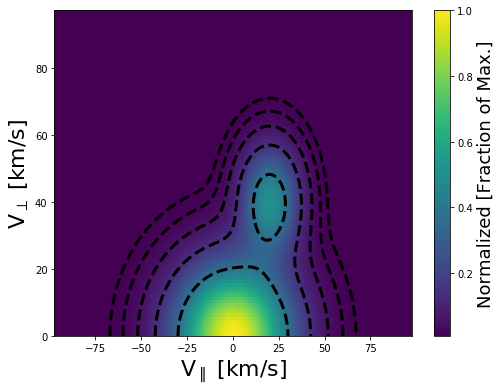

In [6]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

In [7]:
#multi faraday cup solutions
fcs,big_arr = mff.create_multi_fc(dis_vdf,15,v_smp=40)

multi_fc_functions.py:649: RuntimeWarning: invalid value encountered in sqrt
  du = np.sqrt(pcov[1,1])
multi_fc_functions.py:650: RuntimeWarning: invalid value encountered in sqrt
  dw = np.sqrt(pcov[2,2])


In [8]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]


#get angles from big_arr
phis   = np.radians(big_arr[:,3])
thetas = np.radians(big_arr[:,4])

#Number of processors to use when parallel processing
nproc = 8


In [9]:
#Use values with density greater than .1 and an uncertainty less than 10% 
top5 = ((un_angl/n_angl < 4.50) & (n_angl > 1e-1)) #np.sort(n_angl)[-6]
print(un_angl/n_angl)


#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(phis[top5],thetas[top5],-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


[  1.37652841e+00   1.00811821e+11   1.95368625e+00   1.43670167e+01
              nan   1.95749269e+07   1.37580089e+01   2.44991141e-01
   1.97501530e-03   2.60101633e-01   4.63370003e+00   1.96237464e+00
   1.44092601e+01   6.31055607e-01   6.88558137e-02]


/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [10]:
#Get Wper and Wpar vectors using maximum and minimum values
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.max(w_angl[top5])
we = np.min(w_angl[top5])


In [11]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [12]:
if we < 0.9*np.min(w_angl[top5]):
    we = np.min(w_angl[top5])
elif we > 1.1*np.max(w_angl[top5]):
    we = np.max(w_angl[top5])

if wa < 0.9*np.min(w_angl[top5]):
    wa = np.min(w_angl[top5])
elif wa > 1.1*np.max(w_angl[top5]):
    wa = np.max(w_angl[top5])

#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])


In [13]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   30.   15.]
[-591.57189776   37.85953966  -15.31365555   13.68837622   39.35855314
   31.55194071]


In [14]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [19]:
def gauss_2d_reconstruct(z,fcs,cur_vdf):
    """
    Function that reconstructs the 2D velocity distribution in the V parallel
    and V perp reference frame by assuming a 2D Gaussian.
    
    Parameters
    ------------
    z: list
        A list of input parameters used in the 2D velocity reconstruction. 
        The list must contain the following variables in the following order:
        vx,vy,vz,wper,wpar,den where vx is the x-component of the velocity in
        GSE coordinates, vy in the y-component of the velocity in GSE coordinates
        vz is the z-component of the velocity in GSE coordinates
    fcs: dictionary
        A dictionary of Faraday cups created by mff.create_multi_fc()
    cur_vdf: dictionary
        Dictionary of the velocity distribution created by make_discrete_vdf()
        
    Returns
    -------
    y:float or np.array
        The measured current of all Faraday Cups
    """
    vx = cur_vdf['u_gse'][0]
    vy = cur_vdf['u_gse'][1]
    vz = cur_vdf['u_gse'][2]
    
    vx,vy,vz,wper, wpar, den = z
    
    #                   Vx,Vy,Vz,Wper,Wpar, Np
    pls_par = np.array([vx,vy,vz,wper, wpar, den]) 
    
    #Get static variables from cur_vdf to add to creation of new guess VDF
    vel_clip = cur_vdf['pgrid'].max()
    pres     = np.mean(np.diff(cur_vdf['pgrid'][:,0]))
    qres     = np.mean(np.diff(cur_vdf['qgrid'][0,:]))
    
    #Create new VDF guess based on input parameters
    dis_vdf = mdv.make_discrete_vdf(pls_par,cur_vdf['b_gse'],pres=pres,qres=qres,clip=vel_clip) 
    
    looper = []
    #loop over all fc in fcs to populate with new VDF guess
    for i,key in enumerate(fcs.keys()):
        #add variation and store which faraday cup you are working with using key
        #Updated with varying integration sampling function 2018/10/12 J. Prchlik
        inpt_x = fcs[key]['x_meas'].copy()
        g_vdf  = dis_vdf.copy()
        peak   =  fcs[key]['peak'].copy()
        looper.append((inpt_x,g_vdf,samp,key))
        
    #process in parallel
    nproc = 8
    pool = Pool(processes=nproc)
    dis_cur = pool.map(mff.proc_wrap,looper)
    pool.close()
    pool.join()       
    
    
    #break into index value in looper and the 1D current distribution
    index   = np.array(zip(*dis_cur)[1])
    dis_cur = np.array(zip(*dis_cur)[0])


    #get sum squared best fit
    tot_err = np.zeros(dis_cur.shape[0])
    tot_int = np.zeros(dis_cur.shape[0])
    #Get error in each faraday cup
    for j,i in enumerate(index):
        tot_err[j] = np.sum((dis_cur[j,:] - fcs[i]['rea_cur'])**2)
        tot_int[j] = np.sum((fcs[i]['rea_cur'])**2)

    #print(tot_err)
    #total error for all fc
    #tot_err[tot_int < 1e-25] = 0
    #fcs_err = np.median(tot_err)
    fcs_err = np.sqrt(np.sum(tot_err**2) /np.sum(tot_int**2))
    #Remove really bad values from guess fitting

        
    return fcs_err

In [20]:
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':1,'ftol':1,'disp':True})
x2 = time.time()
print(pls_par)
print(powell.x)
print((x2-x1)/60.)

Optimization terminated successfully.
         Current function value: 0.004020
         Iterations: 2
         Function evaluations: 72
[-580.   10.  -10.   20.   30.   15.]
[-591.19085293   21.01973195    3.79711522   35.66336746   23.95956753
   29.48993681]
5.81379750172


In [21]:
#Initial guess around current guess of 2d VDF
pls_par_bad = np.array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12637808, 29.80541342,   14.76697946])
dis_vdf_bad_guess = mdv.make_discrete_vdf(powell.x,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
pred_grid = dis_vdf_bad_guess['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,dis_vdf_bad,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,dis_vdf_bad_guess,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


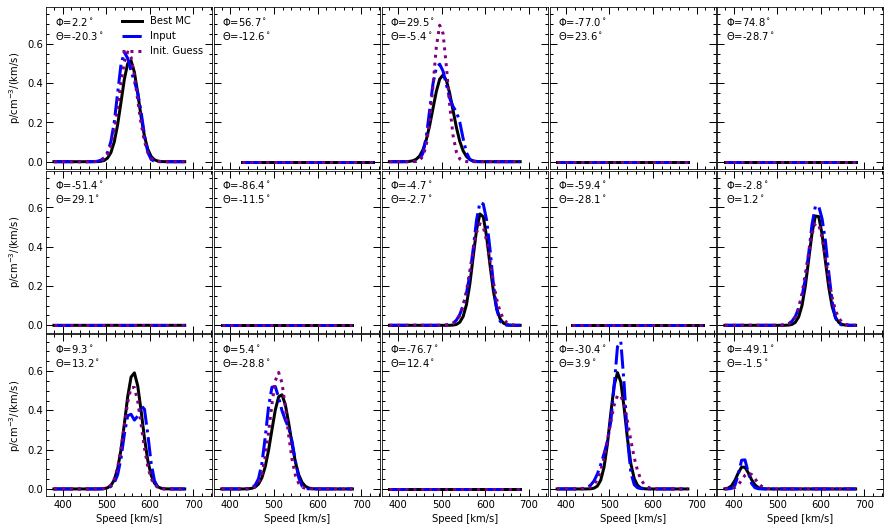

In [22]:
mff.create_fc_grid_plot(fcs)
plt.show()

In [36]:
def gauss_2d_reconstruct_ring(z,fcs,cur_vdf):
    """
    Function that reconstructs the 2D velocity distribution in the V parallel
    and V perp reference frame by assuming a 2D Gaussian.
    
    Parameters
    ------------
    z: list
        A list of input parameters used in the 2D velocity reconstruction. 
        The list must contain the following variables in the following order:
        vx,vy,vz,wper,wpar,den,q_r,p_r,wper_r,wpar_r,peak_r where vx is the x-component of the velocity in
        GSE coordinates, vy in the y-component of the velocity in GSE coordinates
        vz is the z-component of the velocity in GSE coordinates, q_r and p_r are
        the locations of a ring respectively in Vperp and Vpar, wper_r and wpar_r
        are the perpendicular and parallel thermal velocity widths, peak_r is the 
        maximum value of the added ring.
    fcs: dictionary
        A dictionary of Faraday cups created by mff.create_multi_fc()
    cur_vdf: dictionary
        Dictionary of the velocity distribution created by make_discrete_vdf()
        
    Returns
    -------
    y:float or np.array
        The measured current of all Faraday Cups
    """
    vx,vy,vz,wper, wpar, den,q_r,p_r,wper_r,wpar_r,peak_r = z
    
    #                   Vx,Vy,Vz,Wper,Wpar, Np
    pls_par = np.array([vx,vy,vz,wper, wpar, den]) 
    
    #Get static variables from cur_vdf to add to creation of new guess VDF
    vel_clip = cur_vdf['pgrid'].max()
    pres     = np.mean(np.diff(cur_vdf['pgrid'][:,0]))
    qres     = np.mean(np.diff(cur_vdf['qgrid'][0,:]))
    
    #Create new VDF guess based on input parameters
    dis_vdf = mdv.make_discrete_vdf(pls_par,cur_vdf['b_gse'],pres=pres,qres=qres,clip=vel_clip) 
    
    #Add ring to fit
    #Add a positive Gaussian Kernal to "Measured" VDF
    dis_vdf['vdf'] += peak_r*np.exp(- ((dis_vdf['pgrid']-(p_r))/wpar_r)**2. - ((dis_vdf['qgrid']-(q_r))/wper_r)**2.)
    #update the interpolator function
    dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
    
    looper = []
    #loop over all fc in fcs to populate with new VDF guess
    for i,key in enumerate(fcs.keys()):
        #add variation and store which faraday cup you are working with using key
        #Updated with varying integration sampling function 2018/10/12 J. Prchlik
        inpt_x = fcs[key]['x_meas'].copy()
        g_vdf  = dis_vdf.copy()
        peak   =  fcs[key]['peak'].copy()
        looper.append((inpt_x,g_vdf,samp,key))
        
    #process in parallel
    nproc = 8
    pool = Pool(processes=nproc)
    dis_cur = pool.map(mff.proc_wrap,looper)
    pool.close()
    pool.join()       
    
    
    #break into index value in looper and the 1D current distribution
    index   = np.array(zip(*dis_cur)[1])
    dis_cur = np.array(zip(*dis_cur)[0])


    #get sum squared best fit
    tot_err = np.zeros(dis_cur.shape[0])
    tot_int = np.zeros(dis_cur.shape[0])
    #Get error in each faraday cup
    for j,i in enumerate(index):
        tot_err[j] = np.sum((dis_cur[j,:] - fcs[i]['rea_cur'])**2)
        tot_int[j] = np.sum((fcs[i]['rea_cur'])**2)

    #print(tot_err)
    #total error for all fc
    #tot_err[tot_int < 1e-25] = 0
    #fcs_err = np.median(tot_err)
    fcs_err = np.sqrt(np.sum(tot_err**2) /np.sum(tot_int**2))
    #Remove really bad values from guess fitting

        
    return fcs_err

In [59]:
def ring_vdf(cur_vdf,vx,vy,vz,wper,wpar,den,q_r,p_r,wper_r,wpar_r,peak_r):
        #                   Vx,Vy,Vz,Wper,Wpar, Np
    pls_par = np.array([vx,vy,vz,wper, wpar, den]) 
    
    #Get static variables from cur_vdf to add to creation of new guess VDF
    vel_clip = cur_vdf['pgrid'].max()
    pres     = np.mean(np.diff(cur_vdf['pgrid'][:,0]))
    qres     = np.mean(np.diff(cur_vdf['qgrid'][0,:]))
    
    #Create new VDF guess based on input parameters
    dis_vdf = mdv.make_discrete_vdf(pls_par,cur_vdf['b_gse'],pres=pres,qres=qres,clip=vel_clip) 
    
    #Add ring to fit
    #Add a positive Gaussian Kernal to "Measured" VDF
    dis_vdf['vdf'] += peak_r*np.exp(- ((dis_vdf['pgrid']-(p_r))/wpar_r)**2. - ((dis_vdf['qgrid']-(q_r))/wper_r)**2.)
    #update the interpolator function
    dis_vdf['vdf_func'] =  RectBivariateSpline(dis_vdf['pgrid'][:,0],dis_vdf['qgrid'][0,:],dis_vdf['vdf'])
    
    return dis_vdf

In [50]:
x1 = time.time()
if powell.fun > 0.001:
    p_guess = np.zeros(11)
    #Location of the main Solar wind
    p_guess[:6] = powell.x
    #Location of secondary peak
    #q_r, p_r, wper, wpar, peak
    p_guess[6:] = [40,20,15,15,0.5*dis_vdf_bad_guess['vdf'].max()]
    powell_ring = optimize.minimize(gauss_2d_reconstruct_ring,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':1e-4,'ftol':1e-4,'disp':True})

    
x2 = time.time()
print((x2-x1)/60.)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 4888
342.870559351


In [60]:
print(pls_par)
print(p_guess[:6])
print(powell_ring.x[:6])
print(powell_ring.x[6:])

[-580.   10.  -10.   20.   30.   15.]
[-591.19085293   21.01973195    3.79711522   35.66336746   23.95956753
   29.48993681]
[-579.99973678    9.99994808  -10.00010183   20.00013883   30.00009531
   14.99981676]
[  3.99998977e+01   2.00001261e+01   3.26928299e+02   1.49999486e+01
   1.12230007e-04]


In [61]:
#Create new VDF guess based powell solution 

easy_guess_vdf = ring_vdf(dis_vdf,*powell_ring.x)


In [62]:
#Initial guess around current guess of 2d VDF
pred_grid = easy_guess_vdf['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,easy_guess_vdf,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,easy_guess_vdf,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


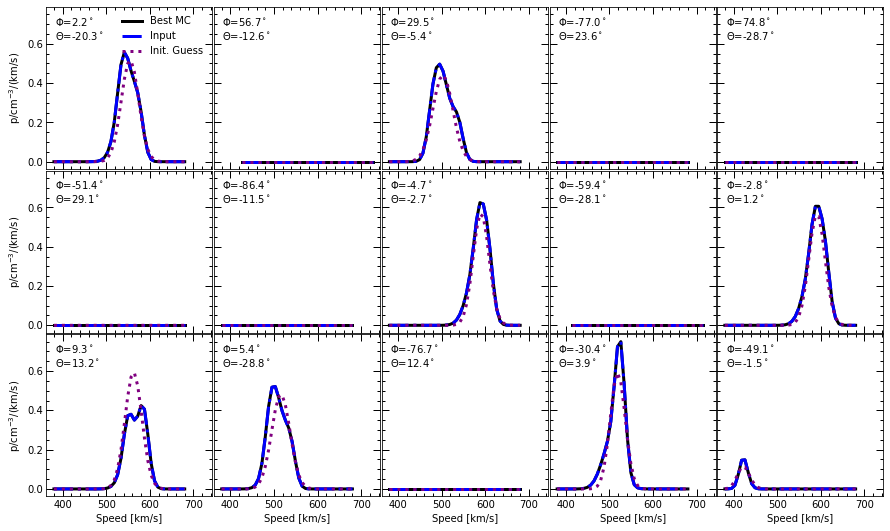

In [63]:
mff.create_fc_grid_plot(fcs)
plt.show()

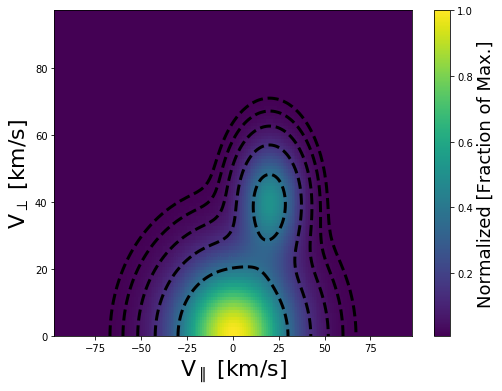

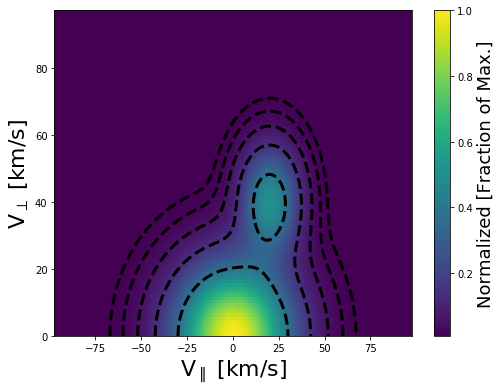

In [64]:
#Initial Guess from measurements
reload(mdv)
mdv.plot_vdf(easy_guess_vdf)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

#difference between real and predicted observations
#how_bad = np.sum((dis_vdf_bad['vdf']-dis_vdf['vdf'])**2)/np.sum(dis_vdf['vdf']**2)
#print(how_bad)

plt.show()

In [65]:
x1 = time.time()
p_guess = np.zeros(11)
#Location of the main Solar wind
p_guess[:6] = powell.x
#MAKE A BAD GUESS 2019/01/24 J. Prchlik
#Location of secondary peak
#q_r, p_r, wper, wpar, peak
p_guess[6:] = [20,10,-15,35,0.1*dis_vdf_bad_guess['vdf'].max()]
bad_guess_powell_ring = optimize.minimize(gauss_2d_reconstruct_ring,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':1e-4,'ftol':1e-4,'disp':True})

    
x2 = time.time()
print((x2-x1)/60.)

Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 37
         Function evaluations: 4502
308.725272401


In [66]:
print(powell_ring.x[:6])
print(powell_ring.x[6:])

[-579.99973678    9.99994808  -10.00010183   20.00013883   30.00009531
   14.99981676]
[  3.99998977e+01   2.00001261e+01   3.26928299e+02   1.49999486e+01
   1.12230007e-04]


In [67]:
#Create new VDF guess based powell solution 

bad_guess_vdf = ring_vdf(dis_vdf,*powell_ring.x)

In [68]:
#Initial guess around current guess of 2d VDF
pred_grid = bad_guess_vdf['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,bad_guess_vdf,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,bad_guess_vdf,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


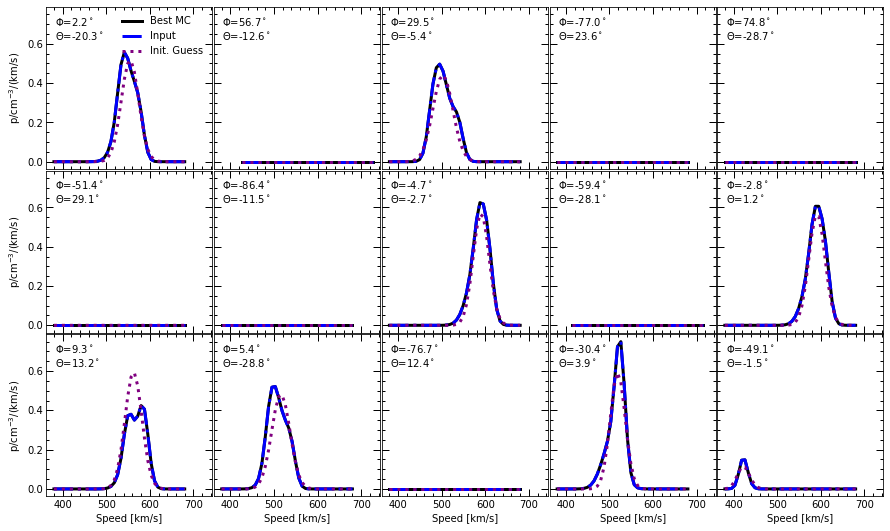

In [70]:
mff.create_fc_grid_plot(fcs)
plt.show()

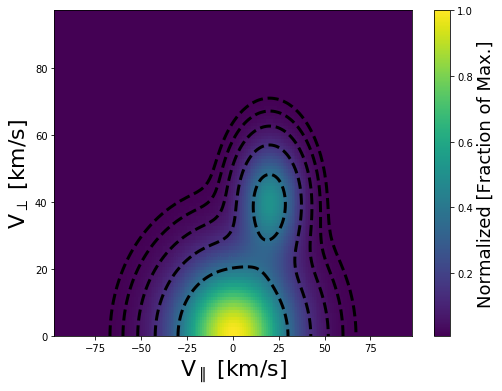

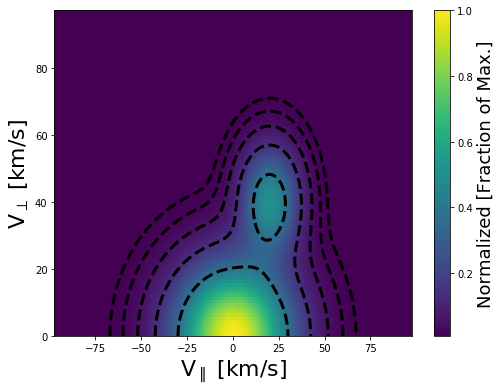

In [69]:
#Initial Guess from measurements
reload(mdv)
mdv.plot_vdf(easy_guess_vdf)

#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)

#difference between real and predicted observations
#how_bad = np.sum((dis_vdf_bad['vdf']-dis_vdf['vdf'])**2)/np.sum(dis_vdf['vdf']**2)
#print(how_bad)

plt.show()